In [5]:
import sys
import os
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.io import savemat
from eels_utils.ElectronSpectrum import ElectronSpectrum as es
from current_densities.current_interpolation import setup_interpolators, get_jx_jy_at

# Constants
Freq_Hz_To_MEEP = 3 * 10**14
Time_Sec_To_MEEP = 1e-6 / 3e8
Time_MEEP_To_Sec = 1 / Time_Sec_To_MEEP
ElectricField_MEEP_TO_SI = 1e-6 * 8.85e-12 * 3e8

# Functions
def drude_material_meep(omega_sec_1, gamma_p_sec_1, epsilon_inf):
    f_p = omega_sec_1 / (2 * np.pi) / Freq_Hz_To_MEEP
    sigma_p = epsilon_inf
    gamma_p = gamma_p_sec_1 / (2 * np.pi) / Freq_Hz_To_MEEP
    return f_p, gamma_p, sigma_p

def lorentz_material_meep(omega_ph_sec_1, gamma_ph_cm_1, epsilon_0, epsilon_inf):
    f_ph = omega_ph_sec_1/ (2 * np.pi) / Freq_Hz_To_MEEP
    gamma_ph = gamma_ph_cm_1 / (2 * np.pi) / Freq_Hz_To_MEEP
    sigma_ph = epsilon_0 - epsilon_inf
    return f_ph, gamma_ph, sigma_ph

def epsilon_theroretical(omega, epsilon_inf, epsilon_0, omega_ph, gamma_ph, omega_p, gamma_p):
    """
    Computes the dielectric function using the given parameters.

    Parameters:
    omega (float): Angular frequency.
    epsilon_inf (float): High-frequency dielectric constant.
    epsilon_0 (float): Static dielectric constant.
    omega_TO (float): Transverse optical phonon frequency.
    Gamma_ph (float): Phonon damping term.
    omega_p (float): Plasma frequency.
    Gamma (float): Damping term for plasma oscillations.

    Returns:
    complex: The computed dielectric function.
    """
    # First term
    background = epsilon_inf
    
    # Second term (resonance contribution)
    lorentz = ((epsilon_0 - epsilon_inf) * omega_ph**2) / (omega_ph**2 - omega**2 - 1j * gamma_ph * omega)
    
    # Third term (plasma contribution)
    drude = -(epsilon_inf * omega_p**2) / (omega * (omega + 1j * gamma_p))
    
    # Total epsilon
    
    
    return background + drude + lorentz



def get_epsilon_at_frequency(freq_hz, medium):
    return medium.epsilon(freq_hz / Freq_Hz_To_MEEP)[0, 0]


In [2]:



epsilon_inf = 12
epsilon_0 = 15
omega_p = 2 * np.pi * 2 * 1e12
gamma_p = 2 * np.pi * 3.3 * 1e12
omega_ph = 2 * np.pi * 6 * 1e12
gamma_ph = 2 * np.pi * 1 * 1e12

f_ph_meep, gamma_ph_meep, sigma_ph_meep = lorentz_material_meep(omega_ph, gamma_ph, epsilon_0, epsilon_inf)
f_p_meep, gamma_p_meep, sigma_p_meep = drude_material_meep(omega_p, gamma_p, epsilon_inf)

# Lorentzian susceptibility for phonons
sus_phonon = mp.LorentzianSusceptibility(frequency=f_ph_meep, sigma=sigma_ph_meep, gamma=gamma_ph_meep)
sus_plasma = mp.DrudeSusceptibility(frequency=f_p_meep, sigma=sigma_p_meep, gamma=gamma_p_meep)

# Create a test material using MEEP's medium class
my_test_material = mp.Medium(epsilon=epsilon_inf, E_susceptibilities=[sus_plasma, sus_phonon])

# Plot epsilon from 5 THz to 9 THz
freq_thz = np.linspace(1, 9, 100)  # Frequency range in THz
freq_hz = freq_thz * 1e12          # Convert THz to Hz

# Calculate epsilon for each frequency
epsilon_values = [get_epsilon_at_frequency(freq, my_test_material) for freq in freq_hz]
epsilon_real = [eps.real for eps in epsilon_values]
epsilon_imag = [eps.imag for eps in epsilon_values]

    # Calculate theoretical epsilon values
epsilon_theoretical_values = [
    epsilon_theroretical(2 * np.pi * freq, epsilon_inf, epsilon_0, omega_ph, gamma_ph, omega_p, gamma_p)
    for freq in freq_hz
]
epsilon_theoretical_real = [eps.real for eps in epsilon_theoretical_values]
epsilon_theoretical_imag = [eps.imag for eps in epsilon_theoretical_values]




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


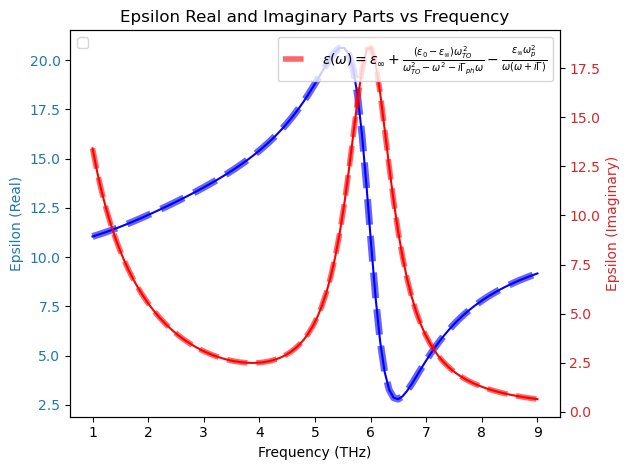

In [3]:
%matplotlib inline
# Plotting
fig, ax1 = plt.subplots()
theoretical_legend = r'$\epsilon(\omega) = \epsilon_{\infty} + \frac{(\epsilon_0 - \epsilon_{\infty}) \omega_{TO}^2}{\omega_{TO}^2 - \omega^2 - i\Gamma_{ph}\omega} - \frac{\epsilon_{\infty} \omega_p^2}{\omega(\omega + i\Gamma)}$'
# Plotting MEEP real part of epsilon
ax1.set_xlabel('Frequency (THz)')
ax1.set_ylabel('Epsilon (Real)', color='tab:blue')
ax1.plot(freq_thz, epsilon_real, 'b-')
ax1.plot(freq_thz, epsilon_theoretical_real, 'b--' , linewidth=5, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a secondary y-axis to plot the imaginary part
ax2 = ax1.twinx()
ax2.set_ylabel('Epsilon (Imaginary)', color='tab:red')
ax2.plot(freq_thz, epsilon_imag, 'r-')
ax2.plot(freq_thz, epsilon_theoretical_imag, 'r--', label=theoretical_legend , linewidth=4, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Epsilon Real and Imaginary Parts vs Frequency')
fig.tight_layout()

plt.show()

### This is a file to check the permittivity model in MEEP

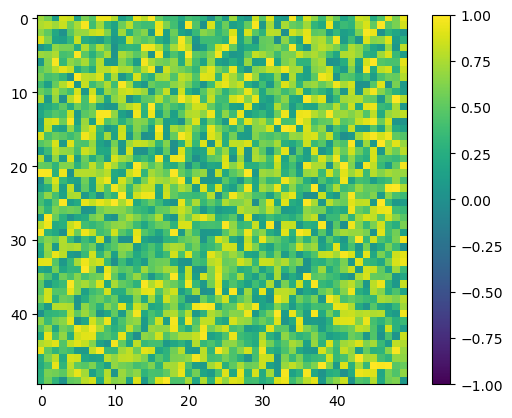

In [19]:
test_mat = np.random.rand(50,50)
plt.imshow(test_mat,clim=(-1,1)) 
plt.colorbar()
